# MVPA MEG Tutorial (Matlab)

[Tutorial starting page](https://github.com/m-guggenmos/megmvpa/).

This tutorial accompanies the preprint titled "Multivariate pattern analysis for MEG: a comprehensive comparison of dissimilarity measures", which is available at [doi.org/10.1101/172619](https://doi.org/10.1101/172619).

**Goal of this tutorial:** compute classification accuracy time courses for a range of classifiers (i.e., MEG decoding)

## Tutorial

We set a seed, in order to make analyses reproducible:

In [1]:
rng(10);

Let's load some data:

In [2]:
root = ''; % This is the /path/to the directory containing the data.
           % We leave it empty here, because the data is located in the current directory.
% Session 1
load(fullfile(root, 'data01_sess1.mat'));
load(fullfile(root, 'labels01_sess1.mat'));
sessions(1).data = data01_sess1;
sessions(1).labels = labels01_sess1;
% Session 2
load(fullfile(root, 'data01_sess2.mat'));
load(fullfile(root, 'labels01_sess2.mat'));
sessions(2).data = data01_sess2;
sessions(2).labels = labels01_sess2;

Now we set some parameters. Only the number of permutations and the number of pseudo-trials are free parameters. The number of conditions, sensors, time points and sessions are derived from the data (i.e., from the sessions variable above).

In [3]:
% Parameters
n_perm = 20;  % number of permutations
n_pseudo = 5;  % number of pseudo-trials
n_conditions = length(unique(sessions(1).labels));
n_sensors = size(sessions(1).data, 2);
n_time = size(sessions(1).data, 3);
n_sessions = length(sessions);

The analytic logic is contained in a nested for loop, with loops for the number of sessions, number of permutations, number of timepoints, number of conditions, and number of conditions again. Overall, the logic contains 4 crucial steps:
1. Compute pseudo-trials for the training and test data
2. Whiten the training data (here using the Epoch method, which is recommended in our manuscript)
3. Fit the classifier to the training data
4. Compute classification accuracy on test data

In [4]:
% pre-load mechanism, for convenience
preload_result = false; % for recomputing the decoding analyses, set to false
if preload_result
    load(fullfile(root, 'result_decoding.mat'))
else
    % We define three classifiers that will be compared: Support Vector Machine, Weighted Robust Distance,
    % Gaussian Naive Bayes
    clfs = {'svm', 'gnb', 'weird'};
    for c = 1:length(clfs)
        result.(clfs{c}) = nan(n_sessions, n_perm, n_conditions, n_conditions, n_time);
    end
    for s = 1:n_sessions

        fprintf('Session %g / %g\n', s, n_sessions)

        X = sessions(s).data;
        y = sessions(s).labels;
        
        conditions = unique(y);
        n_trials = histc(y, conditions);

        for f = 1:n_perm
            fprintf('\tPermutation %g / %g\n', f, n_perm)
            
            % precompute permutations
            ind_pseudo_train = nan(n_conditions, n_conditions, 2*(n_pseudo-1));
            ind_pseudo_test = nan(n_conditions, n_conditions, 2);
            labels_pseudo_train = nan(n_conditions, n_conditions, 2*(n_pseudo-1));
            labels_pseudo_test = nan(n_conditions, n_conditions, 2);
            for c1 = 1:n_conditions
                range_c1 = (c1-1)*(n_pseudo-1)+1:c1*(n_pseudo-1);
                for c2 = 1:n_conditions
                    range_c2 = (c2-1)*(n_pseudo-1)+1:c2*(n_pseudo-1);
                    ind_pseudo_train(c1, c2, 1:2*(n_pseudo - 1)) = [range_c1 range_c2];
                    ind_pseudo_test(c1, c2, :) = [c1 c2];
                    labels_pseudo_train(c1, c2, 1:2*(n_pseudo - 1)) = ...
                        [conditions(c1)*ones(1,n_pseudo-1) conditions(c2)*ones(1,n_pseudo-1)];
                    labels_pseudo_test(c1, c2, :) = conditions([c1 c2]);
                end
            end              
            train_indices = cell(1, n_conditions*(n_pseudo-1));
            test_indices = cell(1, n_conditions);
            for c1 = 1:n_conditions  % separate permutation for each class
                prm_ = randperm(n_trials(c1));                
                prm = cell(1, n_pseudo);
                splitsize = n_trials(c1) / n_pseudo;
                for i = 1:n_pseudo
                    idxs = floor(round((i-1)*splitsize)):floor(round((i)*splitsize))-1;
                    prm{i} = prm_(idxs + 1);
                end                                
                ind = cellfun(@(x)x+sum(n_trials(1:c1-1)), prm, 'UniformOutput', 0);
                xrange = (c1-1)*(n_pseudo-1)+1:c1*(n_pseudo-1);
                for i = 1:length(xrange)
                    train_indices{xrange(i)} = ind{i};
                end
                test_indices{c1} = ind{end};
            end                                

            % 1. Compute pseudo-trials for training and test
            Xpseudo_train = nan(length(train_indices), n_sensors, n_time);
            Xpseudo_test = nan(length(test_indices), n_sensors, n_time);
            for i = 1:length(train_indices)
                Xpseudo_train(i, :, :) = mean(X(train_indices{i}, :, :), 1);
            end
            for i = 1:length(test_indices)
                Xpseudo_test(i, :, :) = mean(X(test_indices{i}, :, :), 1);
            end


            % 2. Whitening using the Epoch method
            sigma_conditions = reshape(squeeze(labels_pseudo_train(1,:,n_pseudo:end))',1,[]);
            sigma_ = nan(n_conditions, n_sensors, n_sensors);
            for c = 1:n_conditions
                % compute sigma for each time point, then average across time
                tmp_ = nan(n_time, n_sensors, n_sensors);
                for t = 1:n_time
                    tmp_(t, :, :) = covCor(Xpseudo_train(sigma_conditions==c, :, t));
                end
                sigma_(c, :, :) = mean(tmp_, 1);
            end
            sigma = squeeze(mean(sigma_, 1));  % average across conditions
            sigma_inv = sigma^-0.5;
            for t = 1:n_time
                Xpseudo_train(:, :, t) = squeeze(Xpseudo_train(:, :, t)) * sigma_inv;
                Xpseudo_test(:, :, t) = squeeze(Xpseudo_test(:, :, t)) * sigma_inv;
            end

            for t = 1:n_time
                for c1 = 1:n_conditions-1
                    for c2 = c1+1:n_conditions
                        % 3. Fit the classifier using training data
                        data_train = Xpseudo_train(ind_pseudo_train(c1, c2, :), :, t);
                        y_train = squeeze(labels_pseudo_train(c1, c2, :));
                        model_svm = svmtrain(y_train, data_train, '-c 1 -q 0 -t 0');
                        model_weird = weirdtrain(y_train, data_train);
                        model_gnb = gnbtrain(y_train, data_train);

                        % 4. Compute and store classification accuracies
                        data_test = Xpseudo_test(ind_pseudo_test(c1, c2, :), :, t);
                        y_train = squeeze(labels_pseudo_test(c1, c2, :));
                        result.svm(s, f, c1, c2, t) = ...
                            mean(svmpredict(y_train,data_test,model_svm,'-q 0 -t 0')==y_train)-0.5;
                        result.weird(s, f, c1, c2, t) = ...
                            mean(weirdpredict(y_train,data_test,model_weird)==y_train)-0.5;
                        result.gnb(s, f, c1, c2, t) = ...
                            mean(gnbpredict(y_train,data_test,model_gnb)==y_train)-0.5;
                    end
                end
            end
        end
    end
    % average across permutations
    for c = 1:length(clfs)
        result_.(clfs{c}) = nan(n_sessions, n_perm, n_conditions, n_conditions, n_time);
    end 
    result_.svm = squeeze(nanmean(result.svm, 2));
    result_.gnb = squeeze(nanmean(result.gnb, 2));
    result_.weird = squeeze(nanmean(result.weird, 2));
    % result_.lda = squeeze(nanmean(result.lda, 2));
    result = result_;
    save(fullfile(root, 'result_decoding.mat'), 'result')
end

Session 1 / 2
	Permutation 1 / 20
	Permutation 2 / 20
	Permutation 3 / 20
	Permutation 4 / 20
	Permutation 5 / 20
	Permutation 6 / 20
	Permutation 7 / 20
	Permutation 8 / 20
	Permutation 9 / 20
	Permutation 10 / 20
	Permutation 11 / 20
	Permutation 12 / 20
	Permutation 13 / 20
	Permutation 14 / 20
	Permutation 15 / 20
	Permutation 16 / 20
	Permutation 17 / 20
	Permutation 18 / 20
	Permutation 19 / 20
	Permutation 20 / 20
Session 2 / 2
	Permutation 1 / 20
	Permutation 2 / 20
	Permutation 3 / 20
	Permutation 4 / 20
	Permutation 5 / 20
	Permutation 6 / 20
	Permutation 7 / 20
	Permutation 8 / 20
	Permutation 9 / 20
	Permutation 10 / 20
	Permutation 11 / 20
	Permutation 12 / 20
	Permutation 13 / 20
	Permutation 14 / 20
	Permutation 15 / 20
	Permutation 16 / 20
	Permutation 17 / 20
	Permutation 18 / 20
	Permutation 19 / 20
	Permutation 20 / 20


Now we plot the average classification accuracy time course by collapsing across sessions and conditions:

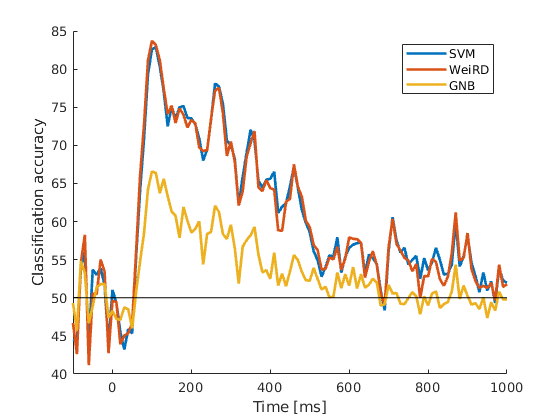

In [5]:
hold on
plot(-100:10:1001, 100*squeeze(nanmean(nanmean(nanmean(result.svm, 1), 2), 3))+50, 'linewidth', 2)
plot(-100:10:1001, 100*squeeze(nanmean(nanmean(nanmean(result.weird, 1), 2), 3))+50, 'linewidth', 2)
plot(-100:10:1001, 100*squeeze(nanmean(nanmean(nanmean(result.gnb, 1), 2), 3))+50, 'linewidth', 2)
plot([-100 1000], [50 50], 'k-')
xlim([-100 1000])
xlabel('Time [ms]')
ylabel('Classification accuracy')
legend('SVM', 'WeiRD', 'GNB')

Already for one participant and a reduced data set (10 insteada of 92 conditions), these results look like canonical decoding time courses. Note that the period -100ms to 0ms is the baseline phase and stimulus onset is at 0ms. In this example, Support Vector Machine and WeiRD outperform Gaussian Naive Bayes.